# Part 2: Downloading Imagery and Extracting NDVI

In the second part of the code, we will deploy libraries such as `EarthAccess`, `shapely` and `rasterio`, to download satellite images relative to our AOI and calculate *Normalised Difference Vegetation Index (NDVI)* values. The latter will then be used to perform zonal statistics and explore the relationship between habitat connectivity (a measure for biodiversity), NDVI and agricultural management type.


In [1]:
#First, let's just check our directory is correct.
import os
print(os.getcwd())

C:\Users\M533\Assignment


## Establishing the Search Area

Now, let's load again our Area of Interest (AOI) shapefile. We want to be able to use the coordinates of our AOI file as our 'search area' when downloading imagery from EarthAccess. Before we do this, we might need to make a few changes depending on our CRS. The code below, loads the AOI shapefile into a GeoDataFrame and checks if the CRS is a projected coordinate system (not WSG84).

In [2]:
import geopandas as gpd
AOI = gpd.read_file('Data_files/Area_of_interest.shp')

if AOI.crs != 'epsg:4326':
    print("Attention: The coordinate system of 'search_area' must be in geographic coordinates (WGS84, EPSG:4326). "
          "Please convert the CRS to WGS84 before proceeding with earthaccess data search to prevent runtime errors.")
else:
    print("The CRS of 'search_area' is correctly set to WGS84 (EPSG:4326). Proceeding with earthaccess data search.")

Attention: The coordinate system of 'search_area' must be in geographic coordinates (WGS84, EPSG:4326). Please convert the CRS to WGS84 before proceeding with earthaccess data search to prevent runtime errors.


Our AOI shapefile seems to be in the wrong coordinate system. Before we proceed, we should transform the CRS to WGS84 (EPSG:4326), which is the CRS EarthAccess expects coordinates to be in.

In [3]:
AOI_wgs84 = AOI.to_crs('+proj=longlat +datum=WGS84')

# Check that the conversion worked
AOI_wgs84.crs

<Geographic 2D CRS: +proj=longlat +datum=WGS84 +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Once this is done, we can perform `unary_union` on the geometry column of the AOI_wgs84 GeoDataFrame. This merges all the individual geometries into a single geometric shape, which represents the combined area of interest (AOI). 

Then, using `outline.bounds` we can retrieve the bounds of our AOI object, which are the minimum and maximum coordinates of the combined geometry. In the code below, the bounds are given as a tuple in the order (min x, min y, max x, max y). 

Lastly, we use the retrieved bounds to define our **search_area**, making sure that we specify `sign=1`. The latter will orient the polygon’s vertices counter-clockwise (an EarthAccess requirement). This  does not change the geometry but simply the order of vertices. 

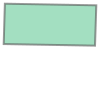

In [7]:
import shapely
outline = AOI_wgs84['geometry'].unary_union

# get the min x, min y, max x, max y values of the Area of Interest
outline.bounds

search_area = shapely.geometry.polygon.orient(outline, sign=1) # a sign of 1 means oriented counter-clockwise

search_area # check that this doesn't actually change the geometry, just the order of the vertices

The code above ensures that the AOI is a single, correctly oriented geometry, which we can use to accurately search for and retrieve geospatial data that falls within this area. Properly defining the search area helps in obtaining relevant data efficiently and ensures the accuracy of our geospatial analyses.

## Downloading Imagery through EarthAccess

### Logging in EarthAccess

Now we can proceed logging in EarthAccess. The code below uses the credentials stored in a `.netrc` file to log in EarthAccess. The `.netrc` file is a configuration file used on Unix-like systems to store usernames and passwords for various remote services like FTP or HTTP1. It allows programs to log in to services without user interaction. If you haven't created one already, explaination on how to set this up can be found in the `README` file on Github.

In [6]:
import earthaccess

earthaccess.login(strategy='netrc')

### Setting up a Time Range

We are interested in downloading satellite images from a specific time range. Ideally, the data included in our analysis should be from a similar period to mitigate discrepancies that may arise from seasonal variations and annual shifts. The code below uses `datetime` to set up a time range (between **start_date** and **end_date**) for data retrieval from EarthAccess. `Datetime` is a Python’s built-in module, which provides classes for manipulating dates and times. We are interested in data relative to Spring 2022.

In [29]:
import datetime

# Define the time range for the data search.
start_date = datetime.datetime(2022, 2, 1)
end_date = datetime.datetime(2022, 6, 30)

### Searching for Datasets

Now we can use our search area coordinates and time range to search for datasets. The code below uses the `search_datasets` function from the EarthAccess library and assigns the result to the variable **datasets**. The `keyword="Sentinel-2"` argument specifies that the search should filter datasets matching the keyword "Sentinel-2". 

In [12]:
datasets = earthaccess.search_datasets(
    keyword="Sentinel-2", # search for datasets that match the keyword "Sentinel-2"
    polygon=search_area.exterior.coords, # search for datasets that intersect AOI,
    temporal=(start_date, end_date)
)

Datasets found: 6


### Extracting Metadata

We can visualise the results to check that the code is indeed performing a search for “Sentinel-2” datasets that intersect with a given search area and fall within a specified time range. The results of this search are stored in the **datasets** variable. We can access and filter through the latter to retrieve specific metadata. The code below gets the first result from the dataset list and retrieves the **'EntryTitle'** and **'ShortName'** information using the `get_umm` function.

In [15]:
dataset = datasets[0] # get the first result
entry_title = dataset.get_umm('EntryTitle')
ds_name = dataset.get_umm('ShortName') 

print(f"Dataset Entry Title: {entry_title}")
print(f"Dataset Short Name: {ds_name}")

Dataset Entry Title: HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0
Dataset Short Name: HLSS30


### Searching for Granules

Metadata information can then be used to query the satellite data database and search for the desired image granules. The code below uses the `search_data` function from the `EarthAccess` library to return a list of data entries (up to 10) from the Sentinel-2 dataset that intersect with the specified AOI and fall within the given time range. Each entry in the list represents a **granule**, which is part of the dataset that covers a specific geographic area and time period.

In [30]:
results = earthaccess.search_data(
    short_name=ds_name, # search for Sentinel-2 granules
    polygon=search_area.exterior.coords, # search for images that intersect our AOI
    count=10, # only show the first 10 results
    temporal=(start_date, end_date)
)

Granules found: 55


To look through the granules found in our search we can run the code below. Once ran, an image displaying our granule should appear on the right-hand side of the return cell. We can use the latter to assess whether image quality and cloud percentage are suitable for our analysis. We can also learn more about the month of data capture by reading the data names. We can change the result shown by changing the indexing in squared brackets. Once we are happy with the granule displayed, we can proceed with the download. 

In [40]:
granule = results[7]  # Indexing starts at 0

granule

Collection: {'EntryTitle': 'HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 17.47719812, 'Latitude': 40.53618553}, {'Longitude': 17.51453839, 'Latitude': 41.5243447}, {'Longitude': 16.19896961, 'Latitude': 41.54559377}, {'Longitude': 16.18114793, 'Latitude': 40.55671174}, {'Longitude': 17.47719812, 'Latitude': 40.53618553}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-02-18T09:49:19.734Z', 'EndingDateTime': '2022-02-18T09:49:19.734Z'}}
Size(MB): 195.31196880340576
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B12.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B04.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B08.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B8A.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T33TXF.2022049T094041.v2.0/HLS.S30.T33TXF.2022049T094041.v2.0.B07.tif']

### Downloading Data

Once we are happy with the granule displayed, we can download the data using the code below. If required, we can change directory name and location by modifying the first line of the code.  

In [42]:
# Create the new folder inside Data_files
save_folder = 'Data_files'  # Specify the correct path to your desired folder
full_path = os.path.join(save_folder, ds_name)
os.makedirs(full_path, exist_ok=True)

# Download the granule into the new directory
downloaded_file = earthaccess.download([granule], full_path)

 Getting 1 granules, approx download size: 0.19 GB


QUEUEING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/18 [00:00<?, ?it/s]

## Calculating NDVI

Once the download is finished our data should be located in a new folder within the Data_files folder. To calculate NDVI we will need the red (ending B04) and NIR (ending B08) bands. The code below opens the data using the `rasterio` library and calculates **NDVI** using the expression:

$$NDVI = \frac{NIR - Red}{NIR + Red}$$

The `pyplot` module from the `matplotlib` library is then used to visualise our results.

The expression above might cause *RunTimeWarnings* to appear signalling zero or invalid values. These are common when performing arithmetic operations with NumPy arrays. To handle these warnings, we can use NumPy’s `seterr` function to ignore these warnings or use `np.nan_to_num` to replace NaNs with zeros (these options are provided in the code below, to use them, simply uncomment the line they are on). We might also decide to mask out the invalid values before plotting. However in our case, this might be due to the fact that at the moment half of our image is capturing water (bodies of water normally have NDVI values of or below 0). We don't need to worry about this as we will be clipping our NDVI raster in the next step.

C:\Users\M533\AppData\Local\Temp\ipykernel_14044\2067971614.py:16: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir - red) / (nir + red)
C:\Users\M533\AppData\Local\Temp\ipykernel_14044\2067971614.py:16: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


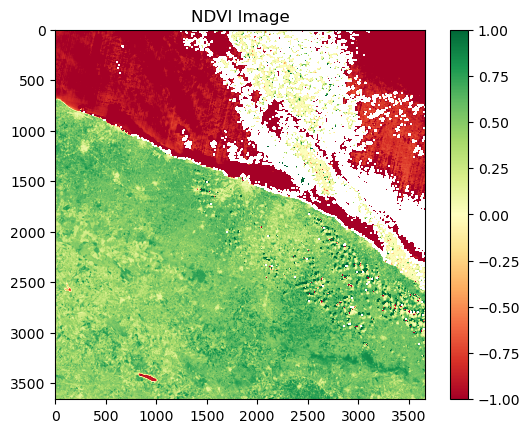

In [4]:
import rasterio as rio
import matplotlib.pyplot as plt

# Suppress divide by zero warning, to use uncomment the line below
# np.seterr(divide='ignore', invalid='ignore')

# read B04 and B08 bands, might need to change the file name if different granule was downloaded
with rio.open('Data_files/HLSS30/HLS.S30.T33TXF.2022049T094041.v2.0.B04.tif') as red_src, \
     rio.open('Data_files/HLSS30/HLS.S30.T33TXF.2022049T094041.v2.0.B08.tif') as nir_src:

    # Read the raster data for the bands
    red = red_src.read(1)
    nir = nir_src.read(1)

    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)

    # Replace NaNs and infinite values with zeros, to use uncomment the line below
    # ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=0.0, neginf=0.0)

    # Plot NDVI
    plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('NDVI Image')
    plt.show()

### Saving NDVI Raster File

In [49]:
# Define the output path for the NDVI raster file
output_ndvi_path = 'Data_files/Output_files/NDVI_output.tif'

# Create a new raster file for the NDVI data
with rio.open(output_ndvi_path, 'w', driver='GTiff', height=ndvi.shape[0], width=ndvi.shape[1],
                       count=1, dtype=ndvi.dtype, crs=red_src.crs, transform=red_src.transform) as dst:
    dst.write(ndvi, 1)

print(f"NDVI data saved to {output_ndvi_path}")

NDVI data saved to Data_files/Output_files/NDVI_output.tif


### Clipping NDVI Raster File to AOI

Now we have an NDVI raster file for the whole granule area, but we are just interested in our AOI. Before we can clip the NDVI Raster to our AOI, we want check the Coordinate Reference System (CRS) of the raster and vector data using the `crs` attribute in rasterio and geopandas respectively.

In [55]:
# Load the NDVI raster
ndvi_path = 'Data_files/Output_files/NDVI_output.tif'
with rio.open(ndvi_path) as ndvi_src:
    raster_crs = ndvi_src.crs
    print(f"Raster CRS: {raster_crs}")

# Load the search area polygon
AOI_path = 'Data_files/Area_of_interest.shp'
AOI = gpd.read_file(AOI_path)
vector_crs = AOI.crs
print(f"Vector CRS: {vector_crs}")

Raster CRS: PROJCS["UTM Zone 33, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Vector CRS: EPSG:32633


If the CRS of our raster and vector data match, we can proceed with clipping our raster data to our AOI. The code below uses the `clip_raster_to_aoi` function defined in the **my_functions.py** file to clip the NDVI raster image to our AOI. 

In [2]:
from my_functions import clip_raster_to_aoi

clip_raster_to_aoi(ndvi_path, AOI_path, 'Data_files/Output_files/clipped_ndvi.tif')

Clipped raster saved to Data_files/Output_files/clipped_ndvi.tif


Now we can plot our clipped NDVI raster file to make sure that it covers our AOI:

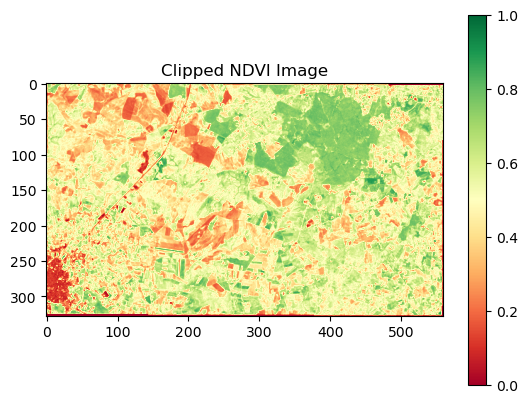

In [7]:
clipped_ndvi_path = 'Data_files/Output_files/clipped_ndvi.tif'
with rio.open(clipped_ndvi_path) as src:
    clipped_ndvi_data = src.read()

plt.imshow(clipped_ndvi_data[0], cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar()
plt.title('Clipped NDVI Image')
plt.show()

This is the end of Part 2 of the code. The [next part](ScriptP3.ipynb) of the code performs zonal statistics using the NDVI data extracted in this section and another raster file displaying habitat connectivity in the area. 